<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/ADDA(20201129_enhance).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install adabelief-pytorch==0.1.0

In [2]:
from adabelief_pytorch import AdaBelief
import warnings 
warnings.simplefilter('ignore')
import torch
from torch import nn
from torch.autograd import Function
from torch import optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import xgboost
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import shuffle
import warnings 
warnings.simplefilter('ignore')

# ADDA 

In [3]:
class ADDA(nn.Module):
  def __init__(self,src_x,src_y,tgt_x,tgt_y):
    super().__init__()
    '''
    src_x : 模擬數據的x type:pd.DataFrame()
    src_y : 模擬數據的y type:pd.DataFrame()
    tgt_x : 真實數據的x type:pd.DataFrame()
    tgt_y : 真實數據的y type:pd.DataFrame()
    '''
    
    # config
    self.device = 'cpu'
    self.x_col = src_x.columns.tolist()
    self.y_col = src_y.columns.tolist()
    self.α = 0.00005
    self.c = 0.01
    self.m = 64
    self.ncritic = 5
    self.input_dim = src_x.shape[1]
    self.output_dim = src_y.shape[1]
    
    # scaled feature
    self.scaler_x =  StandardScaler().fit(src_x.loc[:])
    src_x.loc[:] = self.scaler_x.transform(src_x.loc[:])
    tgt_x.loc[:] = self.scaler_x.transform(tgt_x.loc[:])
    
    # to torch.FloatTensor
    src_x,src_y = torch.FloatTensor(src_x.values),torch.FloatTensor(src_y.values)
    tgt_x,tgt_y = torch.FloatTensor(tgt_x.values),torch.FloatTensor(tgt_y.values)
    
    # make data_iter
    self.src_dataset = TensorDataset(src_x,src_y)
    self.tgt_dataset = TensorDataset(tgt_x,tgt_y)
    
    # src data encoder
    self.SRC_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # target data encoder
    self.TGT_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # regression model
    self.regression = nn.Sequential(
        nn.Linear(128,128),
        nn.Dropout(0.25),# more robust
        nn.ReLU(),
        nn.Linear(128,self.output_dim),
        )
    
    # discriminator model
    self.discriminator = nn.Sequential(nn.Linear(128,1)) # 線性分類器

    # regression loss function
    self.reg_loss = nn.SmoothL1Loss()
    
    # optimizer train_stage_1(回歸訓練) 
    self.S_optimizer = optim.Adam(self.SRC_F.parameters(),lr=1e-4)
    self.R_optimizer = optim.Adam(self.regression.parameters(),lr=1e-4)

    # optimizer train_stage_2(GAN訓練)不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp
    self.T_optimizer = optim.RMSprop(self.TGT_F.parameters(),lr=self.α)
    self.D_optimizer = optim.RMSprop(self.discriminator.parameters(),lr=self.α)
  
  def forward(self,src_x,tgt_x):
    src_feat,tgt_feat = self.SRC_F(src_x),self.TGT_F(tgt_x)
    src_reg,tgt_reg = self.regression(src_feat),self.regression(tgt_feat)
    src_domain,tgt_domain = self.discriminator(src_feat),self.discriminator(tgt_feat)
    return src_reg,src_domain,tgt_reg,tgt_domain
  
  def train_S_R(self,src_x,src_y):
    '''
    input : src_x(FloatTensor),src_y(FloatTensor)
    output : loss(Scalar)
    update_method : 一般監督學習
    '''
    
    self.SRC_F.train()
    self.regression.train()
    
    # forward
    src_feat = self.SRC_F(src_x)
    y_hat = self.regression(src_feat)
    
    # compute loss
    loss = self.reg_loss(y_hat,src_y).mean()
    loss.backward()
    
    # update weight
    self.S_optimizer.step()
    self.R_optimizer.step()
    self.S_optimizer.zero_grad()
    self.R_optimizer.zero_grad()
    
    return loss.item()
  
  def train_T_D(self,src_x,tgt_x,tgt_y):
    '''
    input: src_x(FloatTensor),tgt_x(FloatTensor),tgt_y(FloatTensor)
    return :d_loss(Scalar),t_loss(Scalar),r_loss(Scalar)
    '''
    # 2.生成器和判别器的loss不取log
    # train discriminator ncritic times
    for i in range(self.ncritic):
      src_feat = self.SRC_F(src_x).detach()
      tgt_feat = self.TGT_F(tgt_x).detach()
      d_loss = -torch.mean(self.discriminator(src_feat)) + torch.mean(self.discriminator(tgt_feat))
      d_loss.backward()
      self.D_optimizer.step()
      self.D_optimizer.zero_grad()
      # 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
      for p in self.discriminator.parameters():
        p.data.clamp_(-self.c,self.c)
    
    # train TGT_F
    tgt_feat = self.TGT_F(tgt_x)
    t_loss = -torch.mean(self.discriminator(tgt_feat))
    t_loss.backward()
    self.T_optimizer.step()
    self.T_optimizer.zero_grad()

    # train regression
    tgt_reg = self.regression(tgt_feat.detach())
    r_loss = self.reg_loss(tgt_reg,tgt_y).mean()
    r_loss.backward()
    self.R_optimizer.step()
    self.R_optimizer.zero_grad()
    
    return d_loss.item(),t_loss.item(),r_loss.item()

  def get_predict(self,tgt_x):
    '''
    input: pd.DataFrame()
    output: pd.DataFrame()
    '''
    self.TGT_F.eval()
    self.regression.eval()
    tgt_x = self.scaler_x.transform(tgt_x)
    tgt_x = torch.FloatTensor(tgt_x)
    tgt_feat = self.TGT_F(tgt_x)
    tgt_reg = self.regression(tgt_feat).detach().cpu().numpy()
    tgt_reg = pd.DataFrame(tgt_reg,columns=self.y_col)
    return tgt_reg

# Load Data

In [4]:
src_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/train_4565.csv',index_col=0))
tgt_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/test_250.csv',index_col=0))

# get columns_name
x_col = ['T10','T50','T90','N+A']
y_col = src_data.drop(x_col,axis=1).columns.tolist()

# split some data for final testing
tgt_data,final_test_data = tgt_data.iloc[:200],tgt_data.iloc[200:]

# instance ADDA model

In [5]:
src_x,src_y = src_data[x_col],src_data[y_col]
tgt_x,tgt_y = tgt_data[x_col],tgt_data[y_col]
model = ADDA(src_x,src_y,tgt_x,tgt_y)

# Fit Xgboost

In [6]:
xgb_200 = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:squarederror')).fit(tgt_x,tgt_y)
xgb_4765 = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:squarederror')).fit(src_x.append(tgt_x),src_y.append(tgt_y))

# ADDA train stage_1

ep:0 loss:3.8472681045532227
ep:100 loss:3.1608641147613525
ep:200 loss:1.2675853967666626
ep:300 loss:1.0776885747909546
ep:400 loss:0.7179544568061829
ep:500 loss:0.5678666830062866
ep:600 loss:0.5149616003036499
ep:700 loss:0.5460258722305298
ep:800 loss:0.39816591143608093
ep:900 loss:0.3769454061985016
ep:1000 loss:0.33690452575683594
ep:1100 loss:0.2610108256340027
ep:1200 loss:0.2753463387489319
ep:1300 loss:0.31097257137298584
ep:1400 loss:0.3578333556652069
ep:1500 loss:0.3024985194206238
ep:1600 loss:0.2445990890264511
ep:1700 loss:0.28475266695022583
ep:1800 loss:0.24807734787464142
ep:1900 loss:0.3355891704559326
ep:2000 loss:0.27333810925483704
ep:2100 loss:0.26143160462379456
ep:2200 loss:0.250888854265213
ep:2300 loss:0.2913528382778168
ep:2400 loss:0.2497696429491043
ep:2500 loss:0.23106716573238373
ep:2600 loss:0.3244747817516327
ep:2700 loss:0.35690924525260925
ep:2800 loss:0.36470213532447815
ep:2900 loss:0.3939305245876312


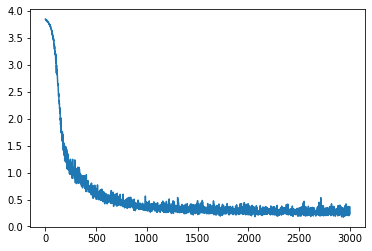

In [7]:
history = []
for ep in range(3000):
  idx = random.sample([*range(len(model.src_dataset))],model.m)
  src_x,src_y = model.src_dataset[idx]
  loss = model.train_S_R(src_x,src_y)
  history.append(loss)
  if ep % 100 == 0:
    print("ep:{} loss:{}".format(ep,loss))
plt.plot(history)

# ADDA train_stage_2

ep:0 d_loss:-0.02726534754037857 t_loss:-0.04609913378953934 r_loss:2.6353588104248047
ep:100 d_loss:-0.1586729884147644 t_loss:-0.5825220346450806 r_loss:1.5807563066482544
ep:200 d_loss:0.06873613595962524 t_loss:-0.5656818151473999 r_loss:1.3832676410675049
ep:300 d_loss:-0.011486388742923737 t_loss:-0.046679504215717316 r_loss:1.1988918781280518
ep:400 d_loss:-0.07922053337097168 t_loss:0.2175937443971634 r_loss:1.1458030939102173
ep:500 d_loss:0.0025031492114067078 t_loss:-0.08340999484062195 r_loss:0.9424806833267212
ep:600 d_loss:-0.0031060874462127686 t_loss:-0.10425093024969101 r_loss:0.9917096495628357
ep:700 d_loss:-0.03992881625890732 t_loss:0.11078837513923645 r_loss:0.8573777675628662
ep:800 d_loss:-0.017893821001052856 t_loss:-0.006044544279575348 r_loss:0.7889215350151062
ep:900 d_loss:0.011121958494186401 t_loss:-0.13328079879283905 r_loss:0.7949339747428894
ep:1000 d_loss:-0.03048427402973175 t_loss:0.0513196624815464 r_loss:0.8271306753158569
ep:1100 d_loss:-0.022794

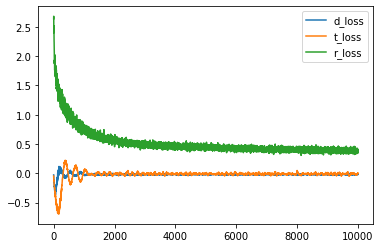

In [8]:
d_history = []
t_history = []
r_history = []
for ep in range(10000):
  tgt_idx = random.sample([*range(len(model.tgt_dataset))],model.m)
  src_idx = random.sample([*range(len(model.src_dataset))],model.m)
  tgt_x,tgt_y = model.tgt_dataset[tgt_idx]
  src_x,src_y = model.src_dataset[src_idx]
  d_loss,t_loss,r_loss = model.train_T_D(src_x,tgt_x,tgt_y)
  d_history.append(d_loss)
  t_history.append(t_loss)
  r_history.append(r_loss)
  if ep % 100 == 0:
    print("ep:{} d_loss:{} t_loss:{} r_loss:{}".format(ep,d_loss,t_loss,r_loss))

plt.plot(d_history,label='d_loss')
plt.plot(t_history,label='t_loss')
plt.plot(r_history,label='r_loss')
plt.legend()
plt.show()

# model predict

In [9]:
x_test = final_test_data[x_col]
y_test = final_test_data[y_col]

In [10]:
adda_y_hat = model.get_predict(x_test)
xgb_200_y_hat = pd.DataFrame(xgb_200.predict(x_test),columns=y_col)
xgb_4765_y_hat = pd.DataFrame(xgb_4765.predict(x_test),columns=y_col)

# evaluate

In [11]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_pred,y_real):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','RMSE','MAPE'])
  for i in y_pred.columns:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'RMSE'] = np.sqrt(mean_squared_error(y_real[i],y_pred[i]))
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [12]:
adda_res = show_metrics(adda_y_hat,y_test)
adda_res

,R2,RMSE,MAPE
C5NP,0.960643,0.838614,37.2399
C5IP,0.94876,0.673442,46.7796
C5N,0.952748,0.074779,40.5206
C6NP,0.912934,0.657282,39.7775
C6IP,0.969177,0.480145,27.9983
C6N,0.700568,0.921809,12.0583
C6A,0.847287,0.446821,43.2462
C7NP,0.624805,0.592511,8.75826
C7IP,0.594742,0.851406,13.5057
C7N,0.933628,1.45454,7.43235


In [13]:
xgb_200_res = show_metrics(xgb_200_y_hat,y_test)
xgb_200_res

,R2,RMSE,MAPE
C5NP,-0.544112,5.25277,145.43
C5IP,-0.934296,4.13768,90.7133
C5N,-1.06418,0.494245,125.572
C6NP,-1.08938,3.21986,111.658
C6IP,-1.32882,4.17355,125.624
C6N,-3.09618,3.40943,49.9035
C6A,-0.330948,1.31909,59.1965
C7NP,-2.90314,1.91106,30.3859
C7IP,-1.24281,2.00294,24.274
C7N,-1.45136,8.83967,69.1029


In [14]:
xgb_4765_res = show_metrics(xgb_4765_y_hat,y_test)
xgb_4765_res

,R2,RMSE,MAPE
C5NP,-0.788202,5.65272,107.684
C5IP,-0.694982,3.87327,121.044
C5N,-1.33525,0.525698,111.004
C6NP,-2.20745,3.98941,93.4351
C6IP,-1.34592,4.18885,124.884
C6N,-5.30479,4.22988,63.5211
C6A,-15.2609,4.6107,1015.11
C7NP,-7.83978,2.876,49.3642
C7IP,-4.01827,2.99604,45.968
C7N,-2.32059,10.2882,51.1814


In [15]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='ADDA', x=y_col, y=adda_res['RMSE']),
    go.Bar(name='XGB_200', x=y_col, y=xgb_200_res['RMSE']),
    go.Bar(name='XGB_4765', x=y_col ,y=xgb_4765_res['RMSE']),
])
# Change the bar mode
fig.update_layout(barmode='group',title='RMSE')
fig.show()

In [16]:
\